In [1]:
%load_ext autoreload
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
from torch import nn
import torch.functional as F
import torchvision
import tqdm
from IPython.display import clear_output
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict

from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn import datasets

from joblib import Parallel, delayed
from multiprocessing import cpu_count

from utils import *
from train_utils import *
from mlp import MLP
from train_utils import get_grad_params

from IPython.core.debugger import set_trace

%autoreload 2

device = torch.device('cuda:0')
N_CPU = cpu_count()

In [2]:
# def sigmoid(X):
    
#     return 1./(1. + np.exp(-X))

# X,y = datasets.make_blobs(n_samples=1000, center_box=(-4, 4), cluster_std=0.2)
# X_s = sigmoid(X + 1)
# X_s -= X_s.mean(0)

# ax1 = plt.subplot(1,2,1)
# ax1.scatter(X[:,0], X[:,1],c=y)
# ax2 = plt.subplot(1,2,2)
# ax2.scatter(X_s[:,0], X_s[:,1],c=y)
# plt.show()

In [3]:
# def R(I,I_m,n=5,sigma=1,gamma=1):
#     return gamma*(I**n / (I**n + I_m**n + sigma**n))

In [4]:
# I_range = np.linspace(0,200,100)
# I_m = I_range.mean()
# plt.plot(I_range,R(I_range, I_m))

In [5]:
mnist_train = torchvision.datasets.MNIST('./data', download=True, train=True,
                                         transform=torchvision.transforms.ToTensor())

mnist_test = torchvision.datasets.MNIST('./data', download=True, train=False,
                                       transform=torchvision.transforms.ToTensor())

# torchvision.datasets.


d = 28**2
n_classes = 10
n_classes_range = np.arange(n_classes)

# baseline random embedding
inpt_test = mnist_test.data.view(-1,d).to(device).type(torch.float32) / 255.
target_test = mnist_test.targets.to(device)
y_test = to_numpy(target_test)

inpt_train = mnist_train.data.view(-1,d).to(device).type(torch.float32) / 255.
target_train = mnist_train.targets.to(device)
y_train = to_numpy(target_train)

mean = inpt_train.mean(0, keepdims=True)
std = inpt_train.std(0, keepdims=True)

inpt_train -= mean
inpt_test -= mean

# std = inpt_train.std(0, keepdims=True)
# std[std == 0] += 1e-5
# inpt_train /= std
# inpt_test /= std

cov_matrix = (inpt_train.T @ inpt_train) / (inpt_train.shape[0]-1)
cov_matrix += torch.eye(cov_matrix.shape[0], dtype=cov_matrix.dtype, device=cov_matrix.device)*1e-2

w,e = torch.linalg.eig(cov_matrix)
w = w.real
e = e.real

inpt_train_pca = inpt_train.clone()
inpt_test_pca = inpt_test.clone()

inpt_train_pca = (inpt_train_pca @ e) / w.unsqueeze(0) 
inpt_test_pca = (inpt_test_pca @ e) / w.unsqueeze(0) 

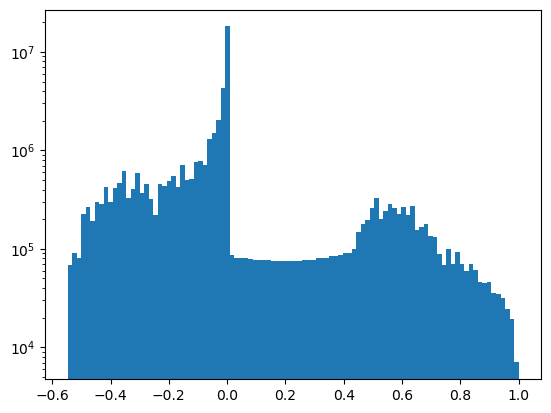

In [6]:
plt.hist(to_numpy(inpt_train.flatten()), bins=100)
plt.yscale('log')
plt.show()

In [7]:
class SimpleDataset(Dataset):
    
    def __init__(self, X,y, sort=False):
        
        super().__init__()
        
        self.X = X
        self.y = y
        self.sort = sort
        
        
    def __getitem__(self, i):
        
        if self.sort:
            mask = self.y.argsort().detach()
            return self.X[mask][i], self.y[mask][i]
        else:
            return self.X[i], self.y[i]
    
    def __len__(self):
        
        return len(self.X)

In [8]:
target_train

tensor([5, 0, 4,  ..., 5, 6, 8], device='cuda:0')

In [10]:
train_dataset = SimpleDataset(inpt_train_pca, target_train, sort=True)
test_dataset = SimpleDataset(inpt_test_pca, target_test, sort=True)

In [11]:
# plt.hist(to_numpy(inpt_train).flatten(), bins=100, alpha=0.6)
# plt.hist(to_numpy(inpt_test).flatten(), bins=100, alpha=0.6)
# plt.yscale('log')
# plt.show()

In [12]:
# X_train = to_numpy(inpt_train)
# X_train -= X_train.mean(0, keepdims=True) 
# pca = PCA()
# pca.fit(X_train)
# plt.plot(np.cumsum(pca.explained_variance_ratio_)[:100])

In [13]:
class DivNorm(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        
        self.gamma = nn.Parameter(torch.randn(1,1))
        self.sigma = nn.Parameter(torch.randn(1,1))
        
        nn.init.xavier_normal_(self.gamma)
        nn.init.xavier_normal_(self.sigma)
        
    
    def forward(self, X):
    
        '''
        X - [d,T]
        '''

        return self.gamma*torch.pow(X,2) / (self.sigma + torch.pow(X,2).mean(1, keepdim=True))
    
n_neurons = 100
n_layers = 3

parameters = {
            'input_dim':d,
            'hidden_dim':n_neurons,
            'n_classes':n_classes,
            'W_requires_grad':True,
            'b_requires_grad':False,
            'activation':nn.Sigmoid(), # nn.Softmax(dim=0)
            'corruption':False,
            'y_H_max':0.5,
            'alpha':0.95,
            'delta_mult':1,
            'n_layers':n_layers,
            'use_bn':True, # idk how it affects 
            'bn_affine':False,
            'device':device
            }

network = MLP(**parameters).to(device)
ce_loss = nn.CrossEntropyLoss()

for n,p in network.named_parameters():
    print(n,p.requires_grad)

W_out True
W_s.0 True
W_s.1 True
W_s.2 True
b_s.0 False
b_s.1 False
b_s.2 False


In [14]:
# plt.hist(to_numpy(network.y_H.flatten()), bins=10)
# plt.ti

In [15]:
# with torch.no_grad():
#     activations, output = network(torch.randn(10000,d, device=device)*0, update_statistics=True)       

In [16]:
# n_layers = parameters['n_layers']
# max_inp = np.empty((n_layers, n_neurons))
# fig, axes = plt.subplots(ncols=n_neurons, nrows=n_layers, figsize=(50, 10))
# for k in range(n_layers):
#     for i, ax in enumerate(axes[k].flatten()):
#         inp_ki = to_numpy(activations[k][0][i]).flatten()
#         ax.hist(inp_ki, bins=50)
#         ax.set_yticks([],[])
        
#         max_inp[k,i] = np.abs(inp_ki).max()

In [17]:
# X = torch.randn(1,3)
# print(X)
# nn.BatchNorm1d(3)(X)

In [18]:
# np.abs(max_inp).max()

In [19]:
# n_layers = parameters['n_layers']
# max_inp = np.empty((n_layers, n_neurons))
# fig, axes = plt.subplots(ncols=n_layers, nrows=1, figsize=(40, 10))
# for k, ax in enumerate(axes):
#     inp_k = to_numpy(activations[k][2]).flatten()
#     ax.hist(inp_k, bins=50)
#     ax.set_yticks([],[])
# plt.tight_layout()
# plt.show()

In [20]:
# network.bn_s[1](activations[0][2].T)

In [21]:
# plt.imshow(max_inp)
# plt.xlabel('# neuron')
# plt.ylabel('# layer')
# # plt.title('max abs. activation')
# plt.title('max abs. input')

# plt.colorbar()
# plt.show()

In [22]:
# foo = torch.randn(5)
# foo = torch.stack([foo]*6)
# nn.BatchNorm1d(5)(foo)

In [23]:
# self = network
# self.y_mean = torch.zeros(self.n_layers, self.hidden_dim, device=self.device)
# self.y_mean_s = defaultdict(list)
# self.delta_mean_s = defaultdict(list)

# network.corruption = False
# max_stimuli = 50

# noise_mult_range = [0,1e-1, 1, 5, 10, 20, 50, 100]

# for noise_mult in noise_mult_range:
#     # zero stimuli presentaton
#     for i in range(max_stimuli):
#         with torch.no_grad():
#             activations, output = network(torch.randn(1,d, device=device)*noise_mult, update_statistics=True)        

In [24]:
        
# onset_time = max_stimuli
# fig, axes = plt.subplots(ncols=n_layers, nrows=1, figsize=(n_layers*7, 5))
# for i, ax in enumerate(axes.flatten()):
#     y_mean_i = np.stack(network.y_mean_s[i], axis=0)
#     ax.plot(y_mean_i[onset_time:,:], linewidth=1)
#     ax.set_title(f'layer: {i}')
# plt.show()

# # fig, axes = plt.subplots(ncols=nl, nrows=1, figsize=(nl*10, 5))
# # for i, ax in enumerate(axes.flatten()):
# #     delta_mean_i = np.stack(network.delta_mean_s[i], axis=0)
# #     ax.plot(delta_mean_i[onset_time:,:], linewidth=0.5)
# # plt.show()

In [25]:
# network.use_bn

In [26]:
# std_window_size = max_stimuli
# onset_time = 40

# for k in range(n_layers):
#     y_mean_k = np.stack(network.y_mean_s[k], axis=0)
#     std_layers_k = []
#     for t in range(len(y_mean_k) - std_window_size - onset_time):
#         t1 = onset_time+t
#         t2 = onset_time+t+std_window_size
#         std_layers_k.append(y_mean_k[t1:t2,:].std(0))
#     std_layers_k = np.array(std_layers_k).mean(1) # [:,d]
#     plt.plot(std_layers_k, label=f'layer: {k+1}')
# plt.yscale('log')
# plt.xlabel(f't, increase noise every {max_stimuli} steps')
# plt.legend(fontsize=15)
# plt.title('Average ' + r'$\sigma$' + ' of neural activity')
# plt.show()

In [27]:
# k=0
# y_mean_i = np.stack(network.y_mean_s[k], axis=0)
# y_mean_i[-1,:] - (to_numpy(network.y_H[k]) + 2.)/5.

In [28]:
def make_ls_solution(X,y,bias=False, alpha=1, onehot=True):
    '''
    X - tensor [N,d]
    y - tensor 
    '''
    y_oh = nn.functional.one_hot(y, num_classes=10).type(X.dtype)
    if not onehot:
        y_oh[y_oh == 0] = -1
    if bias:
        X_ = torch.cat([X, torch.ones_like(X[:,:1], 
                                           device=X.device, 
                                           dtype=X.dtype)], dim=-1)
    else:
        X_ = X.clone()
        
    S = X_.T@X_
    S += torch.eye(S.shape[0], device=X.device, dtype=X.dtype)*alpha # for stability
    W_ls = torch.inverse(S)@X_.T@y_oh
    
    y = X_ @ W_ls
    
    return W_ls, y 

In [29]:
H, output = network(inpt_test)
W_out_ls, output = make_ls_solution(H[-1][-1].T, target_test, bias=True)
target_pred = output.argmax(1)
acc_random = accuracy_score(to_numpy(target_test), to_numpy(target_pred))
print('Acc random', acc_random)

Acc random 0.8096


In [30]:
H_np = to_numpy(H[-1][-1].T)

In [31]:
# # def knn_acc(H_np)
# knn = KNeighborsClassifier(n_neighbors=10)
# knn.fit(H_np, y_test)
# accuracy_score(knn.predict(H_np), y_test)

In [32]:
W_out_ls, output = make_ls_solution(inpt_test, target_test, bias=True)
target_pred = output.argmax(1)
acc_orig = accuracy_score(to_numpy(target_test), to_numpy(target_pred))
# del W_out_ls, output, target_pred

print('Acc orig', acc_orig)

Acc orig 0.8876


In [33]:
epochs = 100

vis_freq = 10
save_freq = 10

batch_size = 200
lr = 1e-3

loss_name = 'Cross-Entropy'
metric_name = 'Accuracy'

loss_function = ce_loss
metric_function = accuracy

SAVE = True

layers_num_iter = [1]

In [2]:
network = MLP(**parameters).to(device)
network.corruption = True

backprop_train = network.W_requires_grad
CONTEXT = torch.enable_grad if backprop_train else torch.no_grad
    
mnist_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
mnist_test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    
metrics = {'train':defaultdict(list),
           'val':defaultdict(list)}

if backprop_train:
    optimizer = torch.optim.Adam(get_grad_params(network.parameters()), lr=lr, weight_decay=1e-3)

if SAVE:
    EXP_COMMENT = '_sigmoid_PCA'
    
    hd = parameters['hidden_dim']
    nl = parameters['n_layers']
    bn = parameters['use_bn']
    corruption = network.corruption
    y_H_max = parameters['y_H_max']
    alpha = parameters['alpha']
    
    backprop_train = parameters['W_requires_grad']

    EXP_NAME =  ('BP' if backprop_train else 'NoBP') +\
                (f'_hd{hd}') +\
                (f'_nl{nl}') +\
                (f'_bn{bn}') +\
                (f'_corrupt{corruption}') +\
                (f'y_H_max{y_H_max}') +\
                (f'alpha{alpha}') +\
                (f'_lr{lr}') +\
                (f'_ep{epochs}') +\
                (f'_bs{batch_size}')

    EXP_NAME += EXP_COMMENT

    EXP_DIR = f'./checkpoints/{EXP_NAME}'

    os.makedirs(EXP_DIR, exist_ok=True)

NameError: name 'MLP' is not defined

In [43]:
!nvidia-smi

Tue Oct 24 20:53:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:01:00.0  On |                  Off |
| 30%   51C    P2    77W / 300W |   1383MiB / 49140MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
for batch, target_batch in mnist_test_dataloader:
    break

NameError: name 'mnist_test_dataloader' is not defined

In [36]:
target_batch

NameError: name 'target_batch' is not defined

In [ ]:
# for layers_num in layers_num_iter:

#     # creating network
#     mlp_parameters['n_layers'] = layers_num
#     network = MLP(**parameters).to(device)

# train
# network.corruption = False
for epoch in tqdm.trange(1,epochs+1):

    #########
    # TRAIN #
    #########
    network.train()

    # initial values
    loss_history_train = []
    metric_history_train = []

    n_train = len(mnist_train_dataloader)

    for batch, target_batch in mnist_train_dataloader:

        inpt = batch.view(-1, d).to(device)
        target_batch = target_batch.to(device)

        with CONTEXT():
            _, output = network(inpt) # [[X, Y, Y_f],...,[X, Y, Y_f]], [d,batch_size]
        
        loss = loss_function(output.T, target_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        target_pred = output.argmax(0)
        metric = metric_function(target_batch, target_pred)
        
        loss_history_train.append(loss.item())
        metric_history_train.append(metric)

    ##### END OF EPOCH #####
    
    metrics['train'][f'{loss_name}'].append(np.mean(loss_history_train))
    metrics['train'][f'{metric_name}'].append(np.mean(metric_history_train))

    ##############
    # VALIDATION #
    ##############
#     network.eval()
    with torch.no_grad():
        
        loss_history_test = []
        metric_history_test = []
        
        for batch, target_batch in mnist_test_dataloader:
            inpt = batch.view(-1, d).to(device)
            target_batch = target_batch.to(device)
            # [[X, Y, Y_f],...,[X, Y, Y_f]], [d,batch_size]
            _, output = network(inpt) 
    
            loss = loss_function(output.T, target_batch)
            target_pred = output.argmax(0)
            metric = metric_function(target_batch, target_pred)
            
            loss_history_test.append(loss.item())
            metric_history_test.append(metric)

    metrics['val'][f'{loss_name}'].append(np.mean(loss_history_test))
    metrics['val'][f'{metric_name}'].append(np.mean(metric_history_test))

    # visualize
    if epoch % vis_freq == 0:

        clear_output()

        plt.rcParams['font.size'] = 20
        plt.rcParams['lines.linewidth'] = 5

        fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,5))
        
        epoch_ = len(metrics['train'][f'{loss_name}'])

        axes[0].plot(metrics['train'][f'{loss_name}'], label='train', alpha=0.5)
        axes[0].plot(metrics['val'][f'{loss_name}'], label='val', alpha=0.5)
        axes[0].set_xlabel('#epoch')
        axes[0].set_ylabel('CE loss')
        axes[0].set_yscale('log')
        axes[0].legend()

        axes[1].plot(metrics['train'][f'{metric_name}'], alpha=0.5)
        axes[1].plot(metrics['val'][f'{metric_name}'], alpha=0.5)
        
        axes[1].hlines(acc_orig, 0, epoch_, 
                       alpha=0.5, color='red', 
                       linestyle='--', label='Acc LS')
        
        axes[1].legend()

        axes[1].set_xlabel('#epoch')
        axes[1].set_ylabel('Accuracy')


        plt.tight_layout()
        plt.show()
        
        ##############
        # LAYERS VIS #
        ##############
        offset = len(test_dataset)
        fig, axes = plt.subplots(ncols=n_layers, nrows=1,figsize=(n_layers*10, 5))
        for i, ax in enumerate(axes.flatten()):
            delta_mean_i = np.stack(network.delta_mean_s[i], axis=0)[-offset:,:]
            ax.plot(delta_mean_i, linewidth=0.5)
            ax.set_title(f'layer: {i}')
            ax.set_xlabel('t')
        plt.show()
        

if SAVE:

    network_dict = {}
    for k,v in network.__dict__.items():
        # not a hidden one
        if k[0] != '_': 
            network_dict[k]=v

    weights_and_history = {'weights':network.state_dict(),
                           'metrics':metrics,
                           'parameters':parameters,
                           'network_things':network_dict}
    
    torch.save(weights_and_history, os.path.join(EXP_DIR, f'weights_and_history_{epoch}'))

  0%|                                                                                                                                        | 0/100 [00:00<?, ?it/s]

In [ ]:
activations, output = network(inpt_train, update_statistics=False)

y_H_train = []
for act_layer in activations:
    y_H_train.append(act_layer[-1].mean(-1))
y_H_train = torch.stack(y_H_train).to(device)
network.y_H = y_H_train.clone()

plt.hist(to_numpy(y_H_train.flatten()), bins=20)
plt.show()

In [21]:
# target_pred_test = target_pred.clone()
# acc_perc_class_test = accuracy_per_class(target_test, target_pred_test)

In [22]:
# onset_time = 0
# nl = parameters['n_layers']
# # fig, axes = plt.subplots(ncols=nl, nrows=1,figsize=(nl*10, 5))
# # for i, ax in enumerate(axes.flatten()):
# #     y_mean_i = np.stack(network.y_mean_s[i], axis=0)
# #     ax.plot(y_mean_i[onset_time:,:], linewidth=0.5)
# # plt.show()

# fig, axes = plt.subplots(ncols=nl, nrows=1,figsize=(nl*10, 5))
# for i, ax in enumerate(axes.flatten()):
#     delta_mean_i = np.stack(network.delta_mean_s[i], axis=0)
#     ax.plot(delta_mean_i[onset_time:,:], linewidth=0.5)
#     ax.set_title(f'layer: {i}')
#     ax.set_xlabel('t')
# plt.show()

In [79]:
# network.corruption = True
# network.training = False
# # network.use_bn = True
# network.activation = nn.Identity()

# delta_mult_init = network.delta_mult

# acc_perc_class_corrupt_s = {}

# delta_mult_range = np.linspace(0,10)

# for delta_mult in delta_mult_range:
    
#     network.delta_mult = delta_mult
#     activations, output = network(inpt_test, update_statistics=False)
#     target_pred = output.argmax(0)
#     acc_perc_class_test_corrupt = accuracy_per_class(target_test, target_pred)
#     acc_perc_class_corrupt_s[delta_mult] = acc_perc_class_test_corrupt
    
# network.delta_mult = delta_mult_init

# acc_corr_gamma = []
# for k,v in acc_perc_class_corrupt_s.items():
#     acc_corr_gamma.append(np.mean(v))

In [80]:
# np.save('acc_corr_gamma_bn-id', acc_corr_gamma)

In [81]:
# acc_corr_gamma_bn = np.load('acc_corr_gamma_bn.npy', allow_pickle=True)
# # acc_corr_gamma_bnid = np.load('acc_corr_gamma_bn-id.npy', allow_pickle=True)
# acc_corr_gamma_nobn = np.load('acc_corr_gamma_nobn.npy', allow_pickle=True)

# plt.plot(delta_mult_range, acc_corr_gamma_bn, label='BN')
# # plt.plot(delta_mult_range, acc_corr_gamma_bnid, label='BN+Id')
# plt.plot(delta_mult_range, acc_corr_gamma_nobn, label='no BN')
# plt.xlabel(r'$\gamma$')
# plt.ylabel('acc.')
# plt.legend()
# plt.show()

In [82]:
# # output_s = []
# # for inpt_test_i in inpt_test:
# #     _, output_i = network(inpt_test_i.unsqueeze(0), update_statistics=False)
# #     output_s.append(output_i)
    
# # output_s = torch.cat(output_s, -1)
# # network.use_bn = Tr

# delta_mult = network.delta_mult
# network.delta_mult = 3
# activations, output_s = network(inpt_test, update_statistics=False)
# target_pred_ = output_s.argmax(0)
# acc_perc_class_test_corrupt_ = accuracy_per_class(target_test, target_pred_)
# # network.delta_mult = delta_mult
# # network.use_bn = False

In [83]:

# width = 0.15 
# multiplier = 0

# # plt.bar(n_classes_range, acc_perc_class_test, width, alpha=0.7, label=r'No corr.')

# for i,(gamma, acc_perc_class_test_corrupt_) in enumerate(acc_perc_class_corrupt_s.items()): 
#     offset = width * (i+1)
# #     plt.bar(n_classes_range+offset, 
# #             acc_perc_class_test_corrupt_, 
# #             width, 
# #             alpha=0.5, 
# #             label=r'$\gamma=$' + f'{gamma}')

#     plt.plot(n_classes_range+offset, 
#                 acc_perc_class_test_corrupt_, 
#                 alpha=0.5, 
#                 label=r'$\gamma=$' + f'{gamma}')
    
# plt.xticks(n_classes_range + width, n_classes_range)
    
# plt.title('Acc. per class')
# plt.legend(bbox_to_anchor=(0.99,0.8))
# plt.show()

In [84]:
# colors = mpl.colormaps['viridis'].colors

# plt.plot(n_classes_range, acc_perc_class_test, alpha=0.7, label=r'No corr.',color='red', linestyle='--')


# for i,(gamma, acc_perc_class_test_corrupt_) in enumerate(acc_perc_class_corrupt_s.items()): 
#     color_ind = int((i/len(delta_mult_range))*len(colors))
    
#     plt.plot(n_classes_range, 
#             acc_perc_class_test_corrupt_, 
#             alpha=0.5, 
#             color=colors[color_ind],
#             label=r'$\gamma=$' + f'{gamma}')
    
# plt.xticks(n_classes_range, n_classes_range)
# plt.title('Acc. per class')
# # plt.legend(bbox_to_anchor=(0.99,0.8))
# plt.show()

In [23]:
network.activation

Sigmoid()

how does accuracy behaves for different initializations? Is there an inductive bias?

In [13]:
network.clear_statistics(update_history=False)

# parameters
network.corruption = True
network.delta_mult = 1
network.activation = nn.Sigmoid()
network.alpha = 0.95
network.use_bn = False

activations_s = defaultdict(list) # outputs for diff. stimuli
acc_per_class_s = []

max_stimuli_repeat = 200

# zero stimuli presentaton 
for i in range(max_stimuli_repeat):
    with torch.no_grad():
        # present stimuli
        activations, output = network(torch.zeros(1,d, device=device), update_statistics=True)
        for l,activations_layer in enumerate(activations):
            activations_s[l].append(to_numpy(activations_layer[-1]).T) 
        # check on the test, given current state of the network - affected by batch-norm
        _, output = network(inpt_test, update_statistics=False)
        target_pred = output.argmax(0) 
        acc_per_class_s.append(accuracy_per_class(target_test, target_pred))

# layers_activations_to_stim = []
# consecutive stimuli presentation
stimuli_presentation = n_classes_range
for stimuli_name in tqdm.tqdm_notebook(stimuli_presentation):
        
        with torch.no_grad():
                # [[X, Y, Y_f],...,[X, Y, Y_f]], [d,batch_size]
            for i in range(max_stimuli_repeat):
                inpt = inpt_test[target_test==stimuli_name][i] # choose first 

                # present stimuli    
                activations, output = network(inpt.unsqueeze(0), update_statistics=True)
                for l,activations_layer in enumerate(activations):
                    activations_s[l].append(to_numpy(activations_layer[-1]).T) 
                
                # check on the test , given current state of the network - affected by batch-norm
                _, output = network(inpt_test, update_statistics=False)
                target_pred = output.argmax(0)
                acc_per_class_s.append(accuracy_per_class(target_test, target_pred))
                
                
# zero stimuli presentaton 
for i in range(max_stimuli_repeat):
    with torch.no_grad():
        
        # present stimuli
        activations, output = network(torch.zeros(1,d, device=device), update_statistics=True)
        for l,activations_layer in enumerate(activations):
            activations_s[l].append(to_numpy(activations_layer[-1]).T) 
        
        # check on the test, given current state of the network - affected by batch-norm
        _, output = network(inpt_test, update_statistics=False)
        target_pred = output.argmax(0) 
        acc_per_class_s.append(accuracy_per_class(target_test, target_pred))
                
acc_per_class_s = np.array(acc_per_class_s)
for k,v in activations_s.items():
    activations_s[k] = np.concatenate(v)

/tmp/ipykernel_665769/851805875.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for stimuli_name in tqdm.tqdm_notebook(stimuli_presentation):


  0%|          | 0/10 [00:00<?, ?it/s]

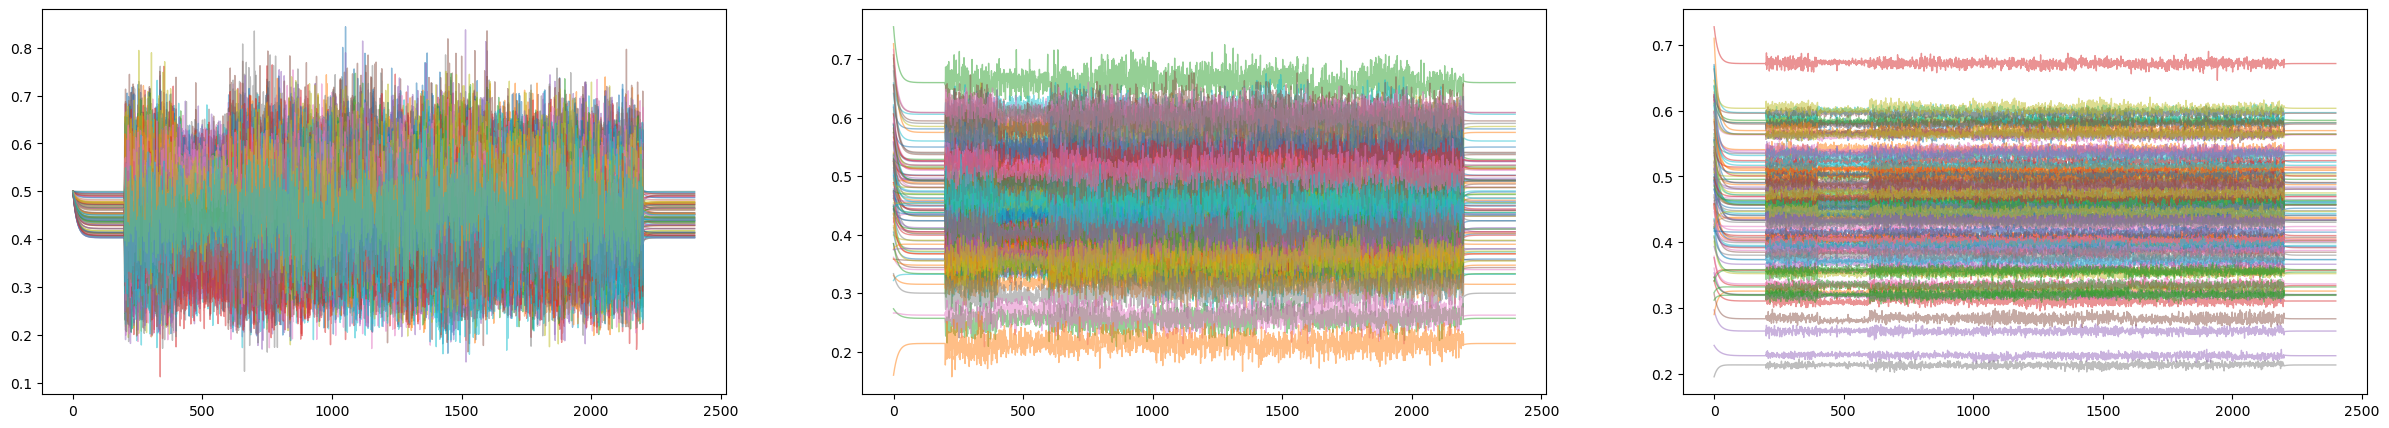

In [15]:
fig, axes = plt.subplots(ncols=n_layers, nrows=1,figsize=(n_layers*10, 5))

for l,act in activations_s.items(): 
    axes[l].plot(act, alpha=0.5, linewidth=1)
plt.show()

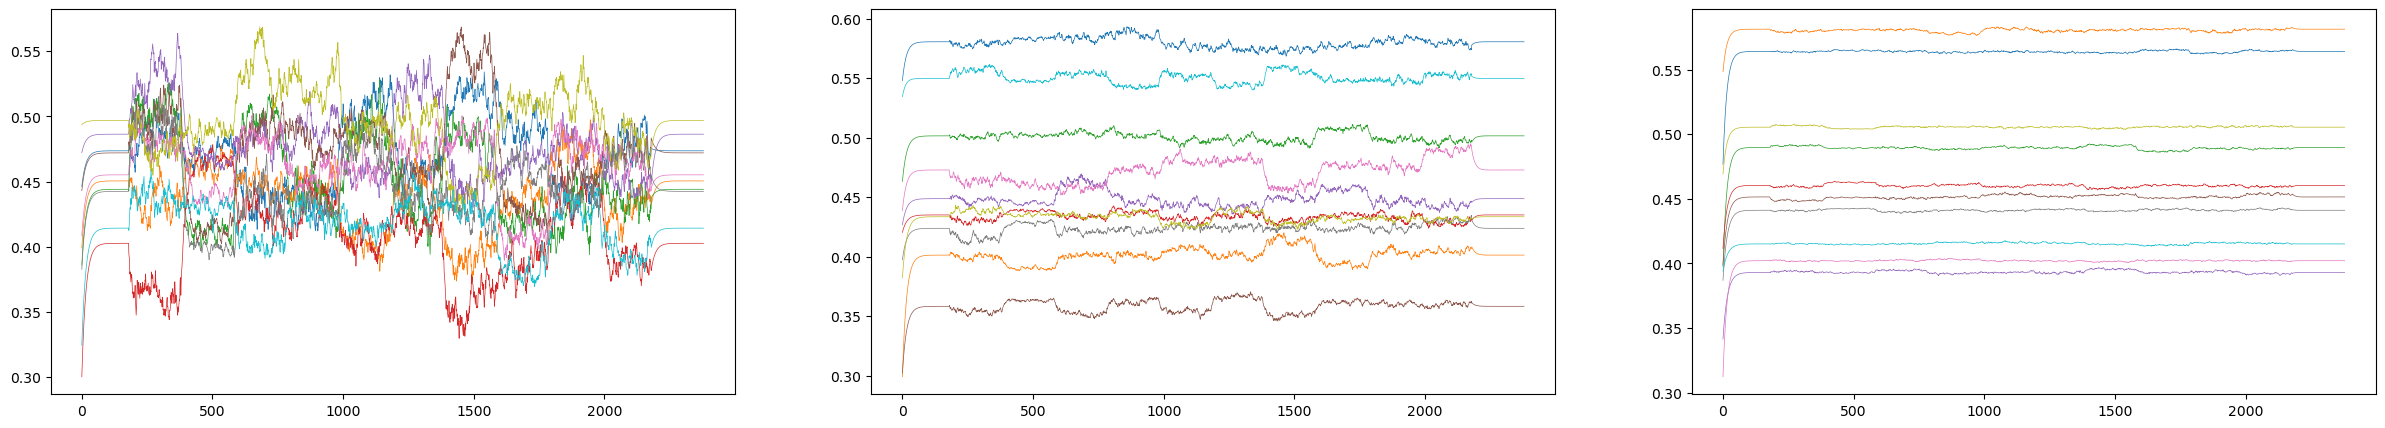

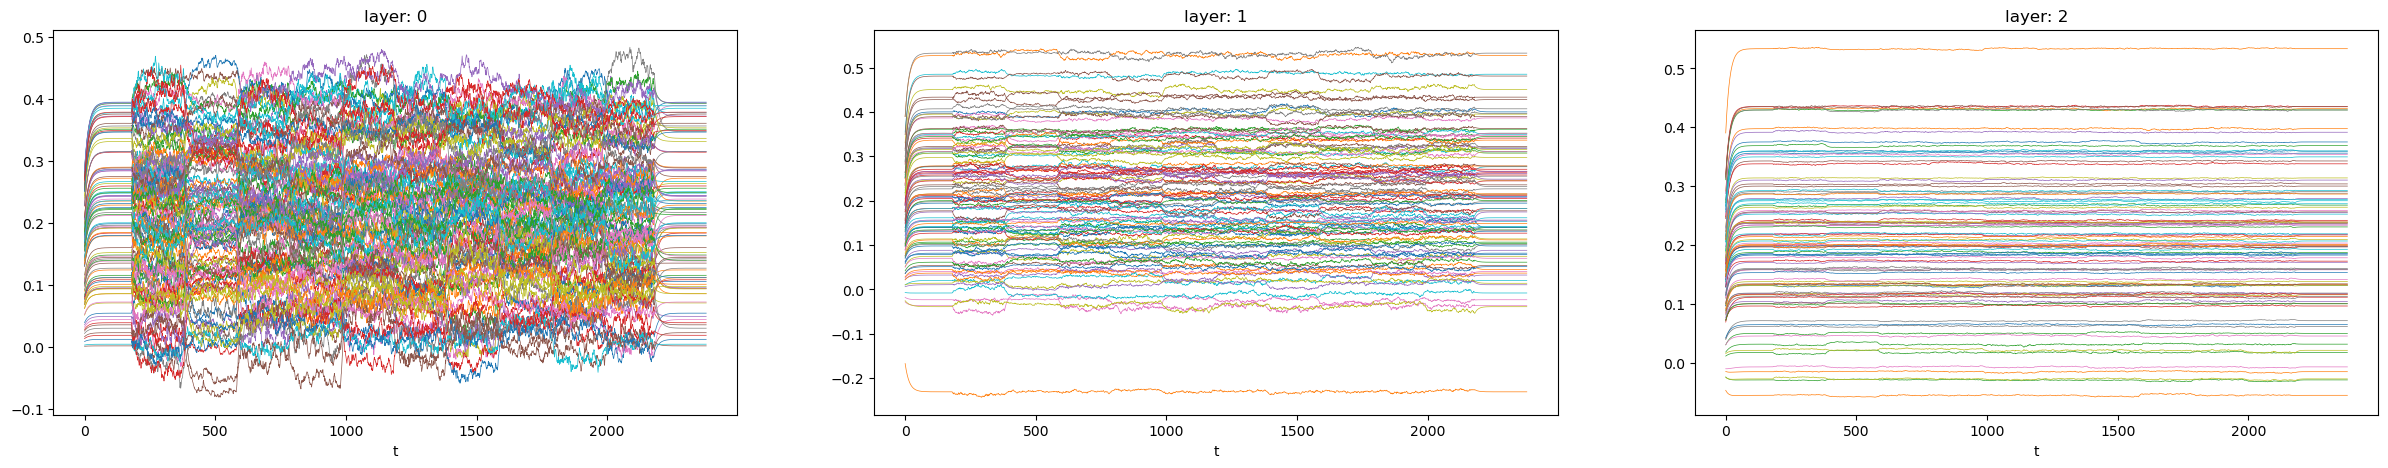

In [18]:
onset_time = 20

y_mean_std = {}
fig, axes = plt.subplots(ncols=n_layers, nrows=1,figsize=(n_layers*10, 5))
for i, ax in enumerate(axes.flatten()):
    y_mean_i = np.stack(network.y_mean_s[i], axis=0)[onset_time:,::10]
    ax.plot(y_mean_i, linewidth=0.5)
    y_mean_std[i] = y_mean_i.std(0).mean()
plt.show()

# delta_mean_std = {}
fig, axes = plt.subplots(ncols=n_layers, nrows=1,figsize=(n_layers*10, 5))
for i, ax in enumerate(axes.flatten()):
    delta_mean_i = np.stack(network.delta_mean_s[i], axis=0)[onset_time:,:]
    ax.plot(delta_mean_i, linewidth=0.5)
    ax.set_title(f'layer: {i}')
    ax.set_xlabel('t')
    
plt.show()

In [320]:
y_mean_std

{0: 0.083526194, 1: 0.044732705, 2: 0.03233901, 3: 0.02581491}

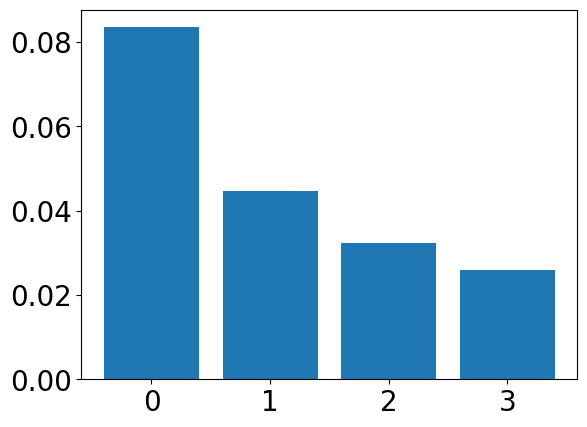

In [321]:
plt.bar(y_mean_std.keys(), y_mean_std.values())
plt.show()

**given that the network is trained**, without BN  

with Identity & no corruption - variance of y_mean and delta increases drastically  
with Identity & corruption - variance of y_mean and delta increases   

with Sigmoid & no corruption - variance of y_mean and delta stays almost constant and small  
__with Sigmoid & corruption__ - variance of y_mean and delta slightly decreases  


**if it is untrained** we see this reduction of std in higher layers - when there is a Sigmoid or Corruption or both! But once there is untrained with Identity and without corruption - std stays the same!

Sigmoid and corruption are favorable for STD reduction!
Surprisingly that corruption is favorable for STD reduction. Is it because neuron becomes mostly corruption-driven? 

So we can have a 

In [322]:
# for stimuli_name in stimuli_presentation:

#     inpt = inpt_test[target_test==stimuli_name][0] # choose first 

#     plt.figure()
#     plt.imshow(to_numpy(inpt.reshape(28,28)), cmap='bone')
#     plt.xticks([])
#     plt.yticks([])
#     plt.show()

In [323]:
# n_vis = int(np.sqrt(max_stimuli_repeat))
# fig, axes = plt.subplots(ncols=n_vis, nrows=n_vis, figsize=(n_vis,n_vis))

# for i, ax in enumerate(axes.flatten()):

#     ax.imshow(to_numpy(inpt_test[target_test==stimuli_name][:max_stimuli_repeat][i].reshape(28,28)))
    
# plt.show()

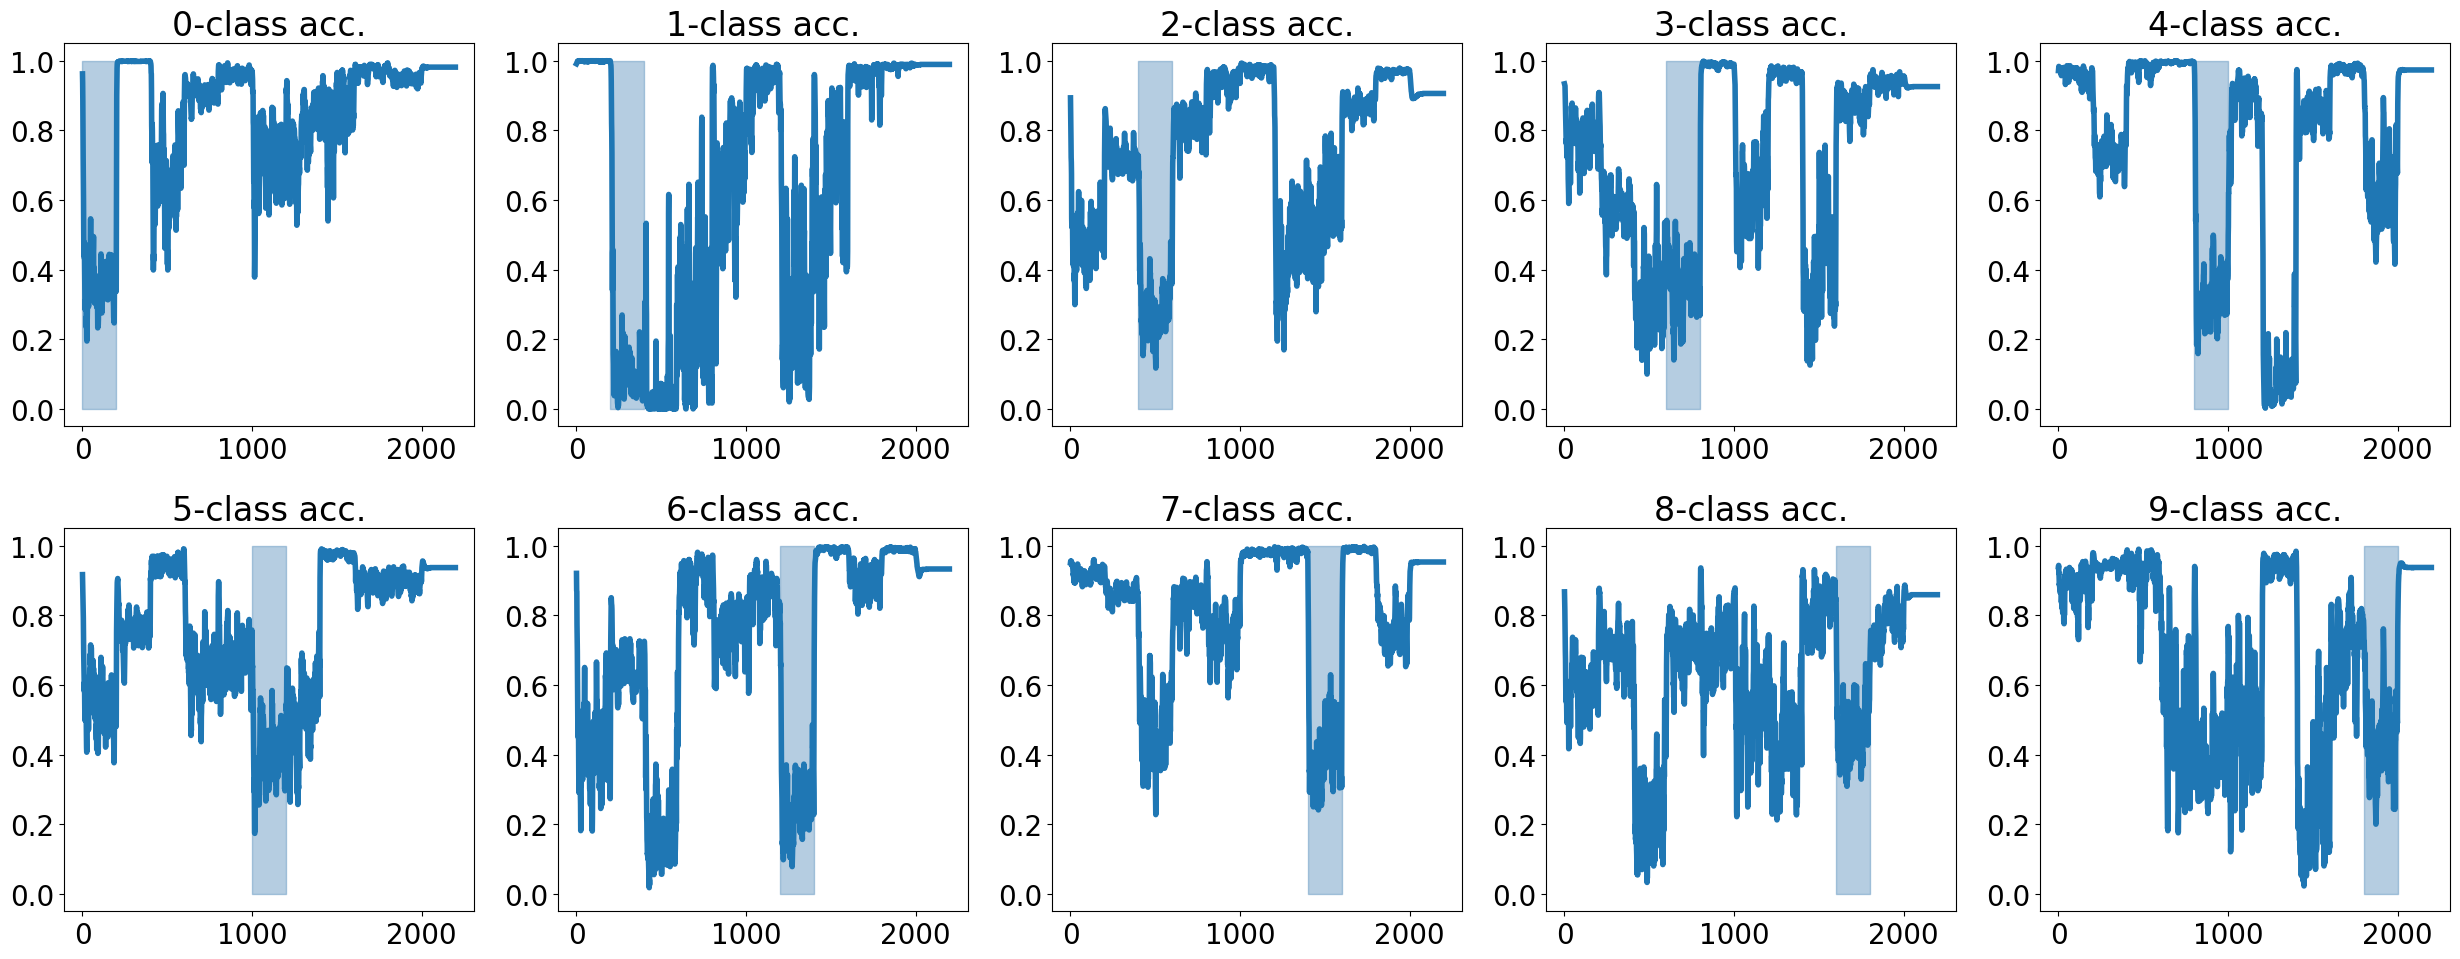

In [324]:
# plt.plot(acc_per_class_s, linewidth=1, label=n_classes_range)
# plt.legend(bbox_to_anchor=(1,1), fontsize=15)

fig, axes = plt.subplots(ncols=n_classes//2, nrows=2, figsize=(5*n_classes//2, 5*2))
for k,ax in enumerate(axes.flatten()):
    ax.plot(acc_per_class_s[max_stimuli_repeat:,k], linewidth=4)
    ax.set_title(f'{k}-class acc.')
    x1 = max_stimuli_repeat*k
    x2 = max_stimuli_repeat*(k+1)
    ax.fill_betweenx([0,1],[x1,x1],[x2,x2], alpha=0.4, color='steelblue')
plt.tight_layout()
plt.show()

In [325]:
def get_cmap_color_i(i, n_total, cmap_name='twilight'):
    
    colors = mpl.colormaps[cmap_name].colors
    N_CMAP = len(colors)
    c_i = int(N_CMAP*(i/n_total))
    
    return colors[c_i]

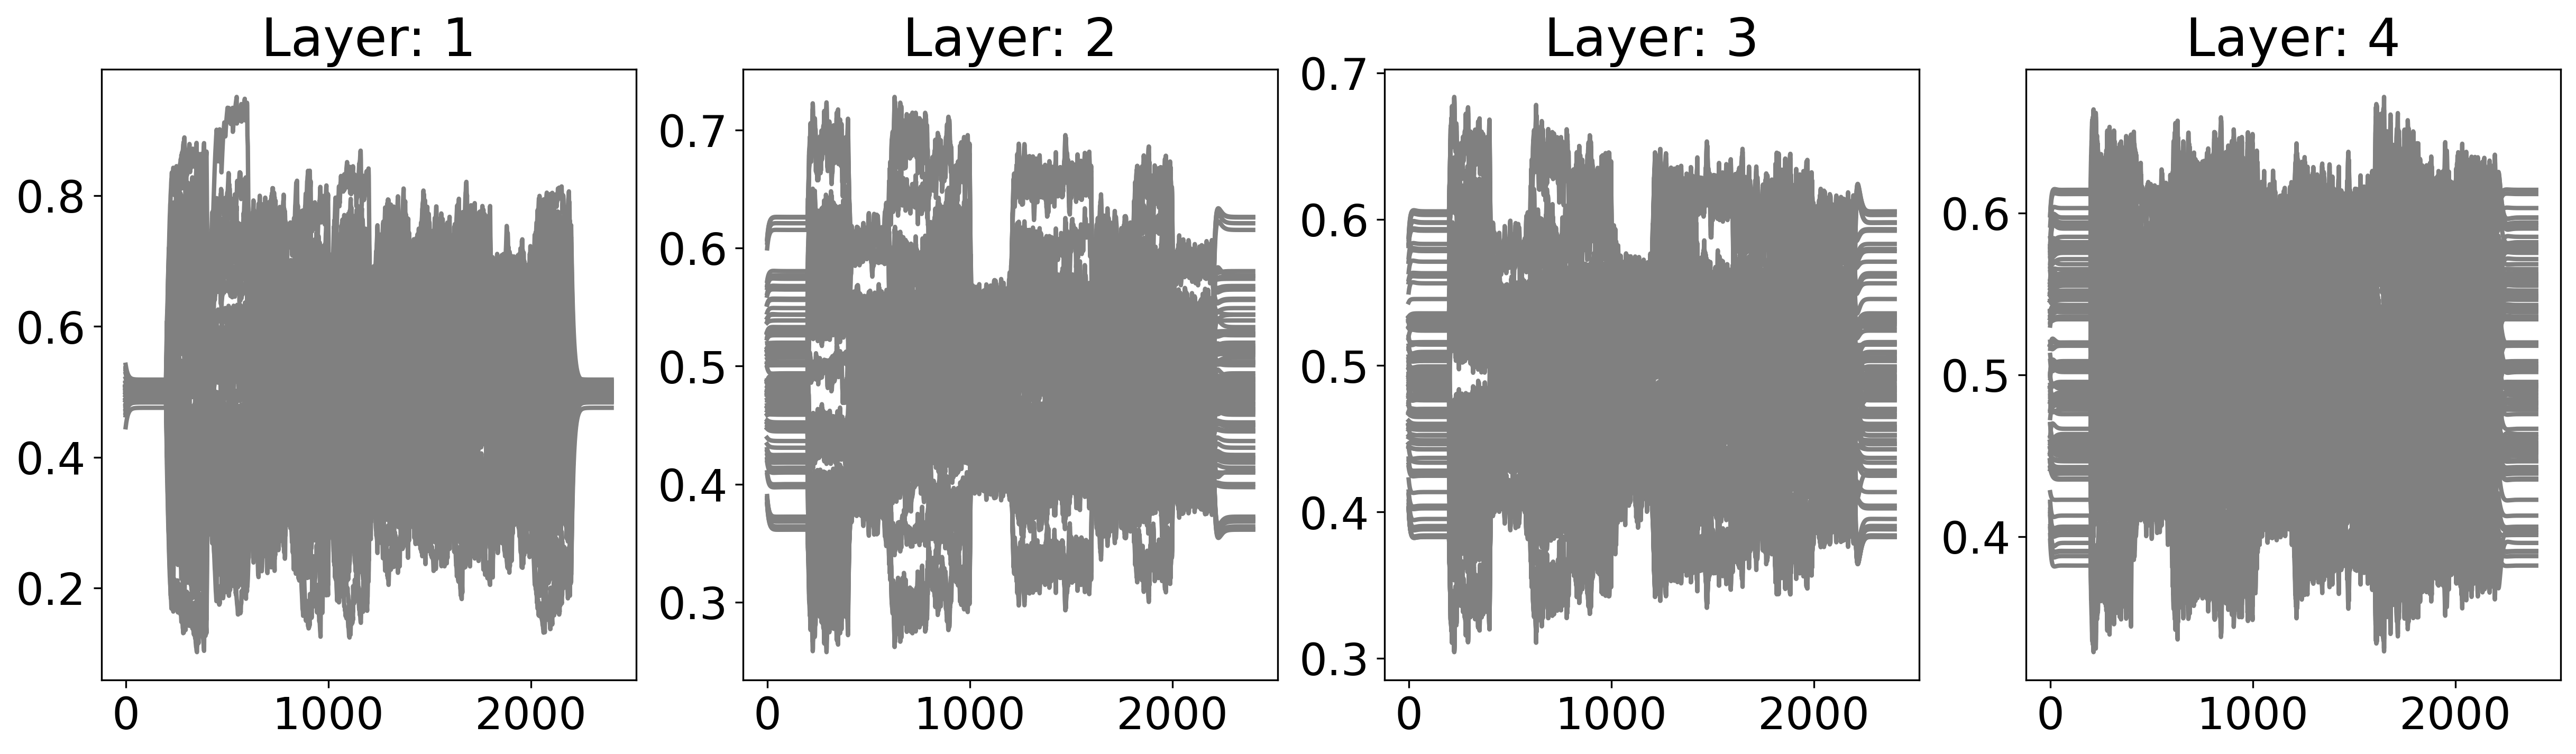

In [328]:
fig, axes = plt.subplots(ncols=n_layers, nrows=1, figsize=(n_layers*5, 5), dpi=300)
for k, ax in enumerate(axes.flatten()):
    
    y_mean_k = np.stack(network.y_mean_s[k], axis=0)
    
    for i,y_mean_ki in enumerate(y_mean_k[:,:].T):
        
        color = get_cmap_color_i(i, n_neurons, cmap_name='twilight')
        ax.plot(y_mean_ki, color='grey', linewidth=2)
    ax.set_title(f'Layer: {k+1}')
plt.show()

In [28]:
# for k in range(nl):
    
#     fig, axes = plt.subplots(ncols=n_neurons, nrows=1, figsize=(n_neurons*10,10), dpi=200)
#     for i, ax in enumerate(axes.flatten()):
        
#         deltas_k_i = np.stack(network.delta_mean_s[k][-1000:])[:,i]
        
#         input_k_i = torch.stack([layers_activations[k][0] for \
#                      layers_activations in layers_activations_to_stim]).squeeze(-1)[:,i]
        
#         ax.hist(to_numpy(input_k_i), alpha=0.5, bins=50)
#         ax.hist(-deltas_k_i, alpha=0.5, bins=50)
        
#     plt.show()
#     break

In [29]:
# # converges to the theoretical firing rate
# # np.abs(np.stack(model.y_mean_s[1], axis=0)[-1:] - to_numpy((model.y_H[1] + 2)/5.)).max()

# layer_i = 1

# I = to_numpy(layers[layer_i][1].squeeze(-1))
# y_H_i = to_numpy(model.y_H[layer_i]) 
# y_mean = model.y_mean_s[layer_i][-1] # last value

# print(np.abs(y_mean - (I + y_H_i + 2)/5.).max())

# print(np.abs(y_mean - (I + y_H_i + 2)/5.).max())

In [30]:
# onset_time = 100
# nl = mlp_parameters['n_layers']
# fig, axes = plt.subplots(ncols=nl, nrows=1, figsize=(nl*10, 5))
# for i, ax in enumerate(axes.flatten()):
#     y_mean_i = np.stack(network.y_mean_s[i], axis=0)
#     ax.plot(y_mean_i[onset_time:,:], linewidth=0.5)
# plt.show()

# fig, axes = plt.subplots(ncols=nl, nrows=1, figsize=(nl*10, 5))
# for i, ax in enumerate(axes.flatten()):
#     delta_mean_i = np.stack(network.delta_mean_s[i], axis=0)
#     ax.plot(delta_mean_i[onset_time:,:], linewidth=0.5)
# plt.show()

In [31]:

# stimuli_presentation = list(range(10))

# for stimuli_name in tqdm.tqdm_notebook(stimuli_presentation):
        
#         with torch.no_grad():
#                 # [[X, Y, Y_f],...,[X, Y, Y_f]], [d,batch_size]
            
#             for inpt in inpt_test[target_test==stimuli_name][:max_stimuli_repeat]:
            
#                 layers, output = network(inpt.unsqueeze(0))
                        
# # target_pred = output.argmax(0)
# # metric = metric_function(target_test, target_pred)

In [32]:
# onset_time = 100
# nl = mlp_parameters['n_layers']
# fig, axes = plt.subplots(ncols=nl, nrows=1, figsize=(nl*10, 5))
# for i, ax in enumerate(axes.flatten()):
#     y_mean_i = np.stack(network.y_mean_s[i], axis=0)
#     ax.plot(y_mean_i[onset_time:,:], linewidth=0.5)
# plt.show()

# fig, axes = plt.subplots(ncols=nl, nrows=1, figsize=(nl*10, 5))
# for i, ax in enumerate(axes.flatten()):
#     delta_mean_i = np.stack(network.delta_mean_s[i], axis=0)
#     ax.plot(delta_mean_i[onset_time:,:], linewidth=0.5)
# plt.show()

In [33]:
# nl = mlp_parameters['n_layers']
# fig, axes = plt.subplots(ncols=nl, nrows=1, figsize=(nl*10, 5))
# for i, ax in enumerate(axes.flatten()):
#     y_mean_i = np.stack(network.y_mean_s[i], axis=0)
#     ax.plot(y_mean_i[-1000:,:], linewidth=1)
# plt.show()

In [34]:
# xrange = np.linspace(-0.1,0.1,10)
# plt.plot(xrange, sigmoid(xrange))
# plt.plot(xrange, 0.25*xrange+0.5)

Text(0.5, 0, 't')

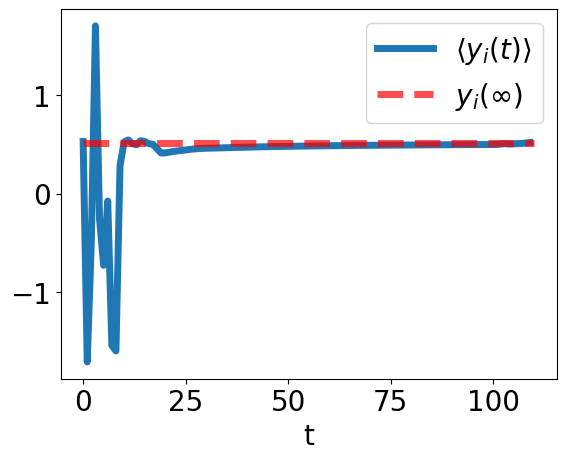

In [264]:
def sigmoid(x):
    return 1./(1. + np.exp(-x))

# def sigmoid_inv(y):
    
#     re
# 
# y_H = np.random.rand(1).item()
lmbd = 1e-1
I = 1e-1

average_activity = list(np.random.randn(10)) #list(np.random.rand(1))
# average_activity = list(np.cumsum(average_activity))

for i in range(100):
    
#     activity = sigmoid(y_H - average_activity[-1])
    
    y_H = np.mean(average_activity[-100:])

    activity = sigmoid(I + y_H - np.mean(average_activity[-10:]))

#     activity = average_activity[-1] + lmbd*(sigmoid(y_H - average_activity[-1]) - average_activity[-1])  
    average_activity.append(activity)
    
y_inf = (I + y_H + 2)/5. # converge to homeostasis is y_H = 0.5!
    
    
plt.plot(average_activity, label=r'$\langle y_i(t) \rangle$')
plt.hlines(y_inf, 0, len(average_activity), linestyle='--', color='red', alpha=0.7, label=f'$y_i(\infty)$')
plt.legend()
plt.xlabel('t')